In [1]:
import pandas as pd
import os

import torch
import torch.nn.functional as F
from torch.optim import Adam

import schnetpack as spk
import schnetpack.atomistic as atm
import schnetpack.representation as rep
from schnetpack import environment
from schnetpack.datasets import QM9

In [2]:
# Check GPU Environment

device = 'cuda'

#ase_env = environment.AseEnvironmentProvider(5)
torch_env = environment.TorchEnvironmentProvider(5, torch.device(device))

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

True


In [3]:
# Read prepared schnet input

from ase.io import read
import numpy as np

atoms = read('./schnet_input_new.xyz', index=':')

# parse properties as list of dictionaries
property_list = []

for at in atoms:
    name = np.array(list(at.info.keys())[0].split(':')[1], dtype=str)
    SA = np.array([float(list(at.info.keys())[1].split(':')[1])], dtype=np.float32)
    PV = np.array([float(list(at.info.keys())[2].split(':')[1])], dtype=np.float32)
    Density = np.array([float(list(at.info.keys())[3].split(':')[1])], dtype=np.float32)
    property_list.append(
        {'Name': name, 'SA' : SA,'PV': PV, 'Density' : Density}
    )

In [4]:
# Prepare dataset for schnet training

# if database already exist, remove the repository
# rm './new_dataset.db'

from schnetpack import AtomsData
new_dataset = AtomsData('./new_dataset.db', available_properties=['SA','PV','Density'], environment_provider=torch_env)
new_dataset.add_systems(atoms, property_list)

In [5]:
# Dataset Example

print('Number of reference calculations:', len(new_dataset))
print('Available properties:')

for p in new_dataset.available_properties:
    print('-', p)
print()

example = new_dataset[0]
print('Properties of molecule with id 0:')

for k, v in example.items():
    print('-', k, ':', v.shape)

Number of reference calculations: 61422
Available properties:
- SA
- PV
- Density

Properties of molecule with id 0:
- SA : torch.Size([1])
- PV : torch.Size([1])
- Density : torch.Size([1])
- _atomic_numbers : torch.Size([194])
- _positions : torch.Size([194, 3])
- _neighbors : torch.Size([194, 44])
- _cell : torch.Size([3, 3])
- _cell_offset : torch.Size([194, 44, 3])
- _idx : torch.Size([1])


/home/parkjunkil/anaconda3/envs/PPN_3/lib/python3.9/site-packages/schnetpack/environment.py:217: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:530.)
  num_repeats = torch.where(pbc, num_repeats, torch.zeros_like(num_repeats))


count    51185.000000
mean       716.810807
std        832.592231
min          0.000000
25%          0.000000
50%        372.293396
75%       1221.560059
max       5415.434082
Name: SA, dtype: float64

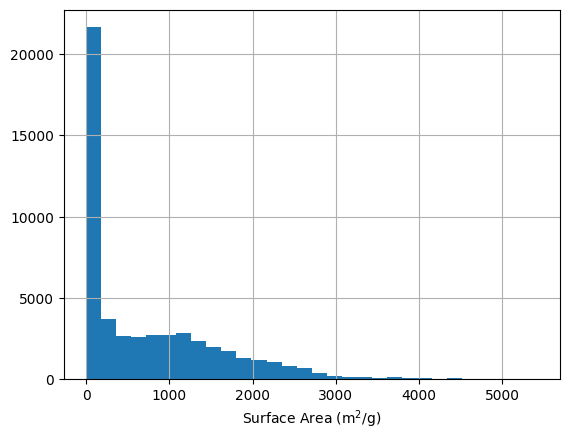

In [7]:
# Plot Statistics

SAs = [new_dataset[i]['SA'].item() for i in range(len(new_dataset))]
SAs = pd.Series(SAs, name='SA')
display(SAs.describe())
ax = SAs.hist(bins=30)
_ = ax.set_xlabel('Surface Area (m$^2$/g)')

In [6]:
# Split dataset into train/val/test

folder = './new_dataset'
if not os.path.exists('new_dataset'): 
    os.makedirs(folder)

num_data = len(new_dataset)
    
train, val, test = spk.train_test_split(
        data=new_dataset,
        num_train=0.8*num_data,
        num_val=0.1*num_data,
        split_file=os.path.join(folder, "split.npz"),
    )

print(f'train data : {len(train)}, test data : {len(test)}, validation data : {len(val)}')

train data : 40948, test data : 5119, validation data : 5118


In [8]:
# Prepare train/val data loader and calculate mean & standard deviation

# hyper-parameter
batch_size = 16

train_loader = spk.AtomsLoader(train, batch_size=batch_size, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=batch_size)

means, stddevs = train_loader.get_statistics(
    'SA', divide_by_atoms=False
)
print(f'Mean Surface Area (m$^2$/g):', means['SA'].item())
print(f'Std. dev. Surface Area(m$^2$/g):', stddevs['SA'].item())

Mean Surface Area (m$^2$/g): 715.4340209960938
Std. dev. Surface Area(m$^2$/g): 832.1250610351562


In [9]:
# Set up schnet model

# hyper-parameter
n_features = 32

schnet = spk.representation.SchNet(
    n_atom_basis=n_features, n_filters=n_features, n_gaussians=20, n_interactions=5,
    cutoff=5., cutoff_network=spk.nn.cutoff.CosineCutoff
)

output_SA = spk.atomistic.Atomwise(n_in=n_features, property='SA',
                                   mean=means['SA'], stddev=stddevs['SA'])

model = spk.AtomisticModel(representation=schnet, output_modules=output_SA)

In [10]:
# multi-gpu setting
model = torch.nn.DataParallel(model, device_ids=[0,1])
model.cuda()

DataParallel(
  (module): AtomisticModel(
    (representation): SchNet(
      (embedding): Embedding(100, 32, padding_idx=0)
      (distances): AtomDistances()
      (distance_expansion): GaussianSmearing()
      (interactions): ModuleList(
        (0-4): 5 x SchNetInteraction(
          (filter_network): Sequential(
            (0): Dense(in_features=20, out_features=32, bias=True)
            (1): Dense(in_features=32, out_features=32, bias=True)
          )
          (cutoff_network): CosineCutoff()
          (cfconv): CFConv(
            (in2f): Dense(in_features=32, out_features=32, bias=False)
            (f2out): Dense(in_features=32, out_features=32, bias=True)
            (filter_network): Sequential(
              (0): Dense(in_features=20, out_features=32, bias=True)
              (1): Dense(in_features=32, out_features=32, bias=True)
            )
            (cutoff_network): CosineCutoff()
            (agg): Aggregate()
          )
          (dense): Dense(in_features=32,

In [11]:
# Set up loss functions for the training

from torch.optim import Adam

# loss function
def mse_loss(batch, result):
    diff = batch['SA']-result['SA']
    err_sq = torch.mean(diff ** 2)
    return err_sq


def mae_loss(batch, result):
    return torch.nn.L1Loss(batch['SA'],result['SA'])


# build optimizer
optimizer = Adam(model.parameters(), lr=1e-3)

In [12]:
# Set up Trainer

# before setting up the trainer, remove previous training checkpoints and logs
#%rm -r ./new_dataset/checkpoints
#%rm -r ./new_dataset/log.csv

import schnetpack.train as trn

loss = trn.build_mse_loss(['SA'])


metrics = [spk.metrics.MeanAbsoluteError('SA')]
hooks = [
    trn.CSVHook(log_path=folder, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

trainer = trn.Trainer(
    model_path=folder,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    #loss_fn=torch.nn.L1Loss(),
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

In [13]:
# Train the model

#device = "cpu" # change to 'cpu' if gpu is not available
n_epochs = 100 # takes about 10 min in my personal setting
trainer.train(device='cuda', n_epochs=n_epochs)

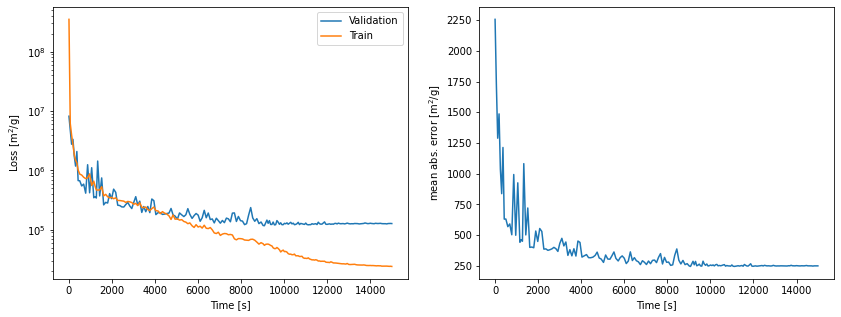

In [14]:
# Trainin Result

import numpy as np
import matplotlib.pyplot as plt

results = np.loadtxt(os.path.join(folder, 'log.csv'), skiprows=1, delimiter=',')

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(time, val_loss, label='Validation')
plt.plot(time, train_loss, label='Train')
plt.yscale('log')
plt.ylabel('Loss [m$^2$/g]')
plt.xlabel('Time [s]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, val_mae)
plt.ylabel('mean abs. error [m$^2$/g]')
plt.xlabel('Time [s]')
plt.show()

In [15]:
# Load trained model

import torch
best_model = torch.load(os.path.join(folder, 'best_model'))

In [16]:
# Inference test data

test_loader = spk.AtomsLoader(test, batch_size=batch_size)

pred_list_test = []
true_list_test = []


err = 0
print(len(test_loader))
for count, batch in enumerate(test_loader):
    # move batch to GPU, if necessary
    batch = {k: v.to(device) for k, v in batch.items()}

    # apply model
    pred = best_model(batch)

    # calculate absolute error
    
    pred_22 = pred['SA'].detach().cpu().numpy()
    true_22 = batch['SA'].detach().cpu().numpy()
    
    for i in range(len(pred_22)):
        pred_list_test.append(pred_22[i][0])
        true_list_test.append(true_22[i][0])
   
    tmp = torch.sum(torch.abs(pred['SA']-batch['SA']))
    tmp = tmp.detach().cpu().numpy() # detach from graph & convert to numpy
    err += tmp

    # log progress
    percent = '{:3.2f}'.format(count/len(test_loader)*100)
    print('Progress:', percent+'%'+' '*(5-len(percent)), end="\r")

err /= len(test)
print('Test MAE', np.round(err, 2), 'm2/g')


65
Test MAE 241.54 m2/g


In [17]:
# Inference train data

pred_list_train = []
true_list_train = []

err = 0
print(len(train_loader))
for count, batch in enumerate(train_loader):
    # move batch to GPU, if necessary
    batch = {k: v.to(device) for k, v in batch.items()}

    # apply model
    pred = best_model(batch)

    # calculate absolute error
    
    pred_22 = pred['SA'].detach().cpu().numpy()
    true_22 = batch['SA'].detach().cpu().numpy()
    
    for i in range(len(pred_22)):
        pred_list_train.append(pred_22[i][0])
        true_list_train.append(true_22[i][0])
   
    tmp = torch.sum(torch.abs(pred['SA']-batch['SA']))
    tmp = tmp.detach().cpu().numpy() # detach from graph & convert to numpy
    err += tmp

    # log progress
    percent = '{:3.2f}'.format(count/len(train_loader)*100)
    print('Progress:', percent+'%'+' '*(5-len(percent)), end="\r")

err /= len(train)
print('Train MAE', np.round(err, 2), 'm2/g')

512
Train MAE 162.51 m2/g


R2 Score - Test : 0.845398
R2 Score - Train : 0.935184


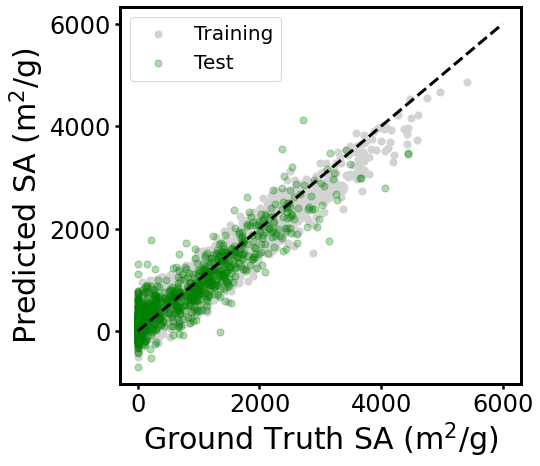

In [22]:
# Plot parity plot

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import matplotlib as mpl


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.axisbelow'] = True
#plt.rc('xtick', labelsize=24)
#plt.rc('ytick', labelsize=24)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['axes.linewidth'] = 3
plt.rcParams['font.size']=24

r2_test = r2_score(true_list_test, pred_list_test)
r2_train = r2_score(true_list_train, pred_list_train)

plt.figure(figsize=(8,7))


print('R2 Score - Test : %3f' %(r2_test))
print('R2 Score - Train : %3f' %(r2_train))


a = np.linspace(0,6000)
plt.plot(a,a,c='black',linestyle='dashed',linewidth=3)


plt.scatter(true_list_train,pred_list_train,c='lightgray',marker='o', label='Training', s = 50)
plt.scatter(true_list_test,pred_list_test,c='green', alpha=0.3, marker='o', label='Test', s = 50)


plt.ylabel('Predicted SA (m$^2$/g)', fontsize = 30)
plt.xlabel('Ground Truth SA (m$^2$/g)', fontsize = 30)
plt.legend(prop={'size': 20})

plt.tight_layout()

#plt.show()

#plt.savefig("schnet_sa.jpg",dpi=400)
#plt.savefig('schnet_sa.svg', dpi=500, format = 'svg')
